In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyarrow import parquet as pq
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from scipy.stats import spearmanr, entropy
from scipy.special import softmax

import sys
sys.path.append("..")
sys.path.append("pLMtrainer")
from pLMtrainer.utils import run_eval_metrics

np.random.seed(42)

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### MISC

In [2]:
parquet_path = "../data/frustration/v7_frustration_2.parquet.gzip"

In [ ]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id,frst_class_3
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70,"[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, ..."
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20,"[0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, ..."


In [34]:
len(df)

982852

In [35]:
df_train = df[df["set"] == "train"]
df_val = df[df["set"] == "val"]
df_test = df[df["set"] == "test"]

In [40]:
np.unique(np.concatenate(df_val["frst_class_3"].values), return_counts=True)[1] / sum(np.unique(np.concatenate(df_val["frst_class_3"].values), return_counts=True)[1])

array([0.11808951, 0.50213119, 0.37977931])

In [36]:
np.concatenate(df["res_idx"].to_numpy()).shape

(186414569,)

In [ ]:
np.concatenate(df_train["res_idx"].to_numpy()).shape, \
np.concatenate(df_val["res_idx"].to_numpy()).shape, \
np.concatenate(df_test["res_idx"].to_numpy()).shape

((170311084,), (5264676,), (10838809,))

In [56]:
np.where(np.concatenate(df_train["res_idx"].to_numpy()) <= 512)[0].shape, \
np.where(np.concatenate(df_val["res_idx"].to_numpy()) <= 512)[0].shape, \
np.where(np.concatenate(df_test["res_idx"].to_numpy()) <= 512)[0].shape

((157560113,), (4923399,), (9583226,))

In [33]:
res_count = [len(s) for s in df["full_seq"].tolist()]
res_count = np.array(res_count)
res_count

array([362, 556, 255, ..., 422, 285, 252], shape=(982852,))

In [34]:
sum(res_count)

np.int64(442719427)

In [35]:
frst_count = [len(s) for s in df["res_seq"]]
frst_count = np.array(frst_count)
frst_count

array([163, 360, 108, ..., 108,  67,  96], shape=(982852,))

In [36]:
sum(frst_count)

np.int64(186414569)

In [37]:
used_frst_res = [sum(s <= 512) for s in df["res_idx"].tolist()]
sum(used_frst_res)

np.int64(172066738)

In [11]:
sum(used_frst_res) / sum(frst_count), sum(used_frst_res) / sum(res_count)

(np.float64(0.9758412069176846), np.float64(0.4108945912599403))

## OLD SPLIT

### S_OLD_CLS_REG 
### S_OLD_CLS_REG_BIN

In [ ]:
S_CLS_REG_OLD = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setold_val_preds.npz"))
S_CLS_REG_BIN_OLD = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setold_val_preds.npz"), bin_regression_for_classification=True)

In [203]:
print(S_CLS_REG_OLD["cls_report"])

              precision    recall  f1-score   support

           0     0.6380    0.4846    0.5508     58802
           1     0.7714    0.8324    0.8008    226501
           2     0.8612    0.8433    0.8521    181668

    accuracy                         0.7929    466971
   macro avg     0.7569    0.7201    0.7346    466971
weighted avg     0.7895    0.7929    0.7893    466971



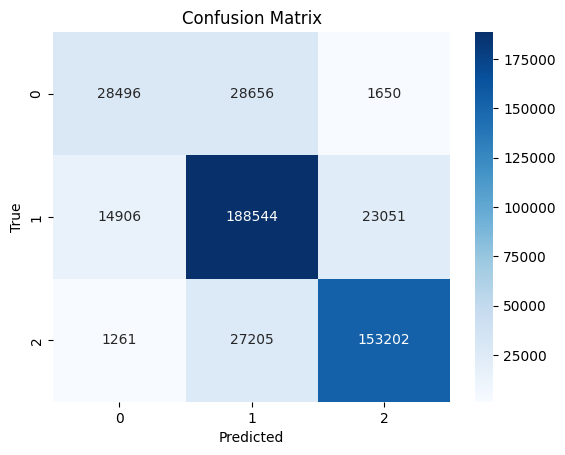

In [209]:
sns.heatmap(S_CLS_REG_OLD["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [206]:
print(S_CLS_REG_OLD["spearman_r"]), print(S_CLS_REG_OLD["mean_absolute_error"]), print(S_CLS_REG_OLD["r2_score"])

0.8378899254536505
0.3772478401660919
0.6953229308128357


(None, None, None)

In [210]:
print(S_CLS_REG_BIN_OLD["cls_report"])

              precision    recall  f1-score   support

           0     0.7336    0.2621    0.3862     58802
           1     0.7141    0.9196    0.8039    226501
           2     0.9137    0.7760    0.8392    181668

    accuracy                         0.7809    466971
   macro avg     0.7871    0.6526    0.6764    466971
weighted avg     0.7942    0.7809    0.7651    466971



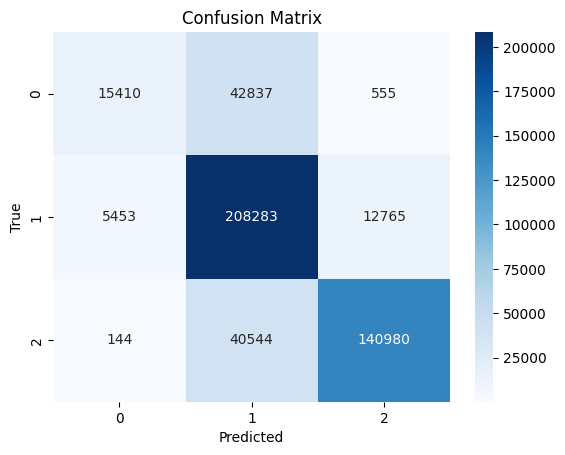

In [211]:
sns.heatmap(S_CLS_REG_BIN_OLD["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### S_OLD_REG (BIN FOR CLS)

In [ ]:
# adding the masked_cls_targets since in older version they were not saved
cls_targets = np.load("../data/it4/it4_S_reg_cls_protT5_setold_val_preds.npz")
s_reg_old = dict(np.load("../data/it4/it4_S_reg_protT5_setold_val_preds.npz"))
s_reg_old["cls_targets"] = cls_targets["cls_targets"]
s_reg_old["masked_cls_targets"] = cls_targets["masked_cls_targets"]
np.savez("../data/it4/it4_S_reg_protT5_setold_val_preds_2.npz", **s_reg_old)

In [ ]:
S_REG_OLD = run_eval_metrics(np.load("../data/it4/it4_S_reg_protT5_setold_val_preds_2.npz"), bin_regression_for_classification=True)

In [221]:
print(S_REG_OLD["cls_report"])

              precision    recall  f1-score   support

           0     0.7297    0.2672    0.3912     58802
           1     0.7172    0.9144    0.8039    226501
           2     0.9079    0.7829    0.8408    181668

    accuracy                         0.7817    466971
   macro avg     0.7849    0.6548    0.6786    466971
weighted avg     0.7930    0.7817    0.7663    466971



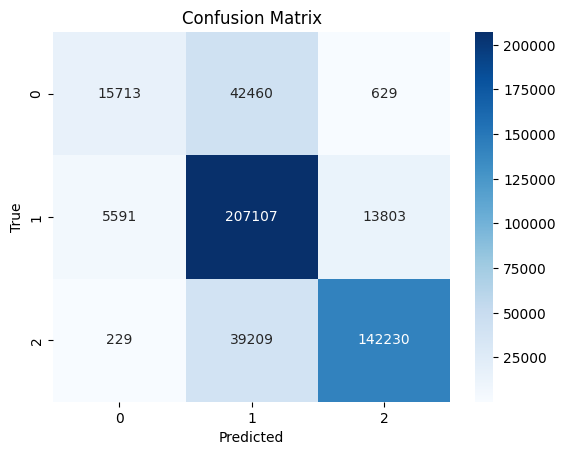

In [222]:
sns.heatmap(S_REG_OLD["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [223]:
print(S_REG_OLD["spearman_r"]), print(S_REG_OLD["mean_absolute_error"]), print(S_REG_OLD["r2_score"])

0.8409658200605362
0.3673193156719208
0.7057963609695435


(None, None, None)

### S_OLD_CLS

In [226]:
S_CLS_OLD = run_eval_metrics(np.load("../data/it4/it4_S_cls_protT5_setold_val_preds.npz"), regression=False)

In [227]:
print(S_CLS_REG_OLD["cls_report"])

              precision    recall  f1-score   support

           0     0.6380    0.4846    0.5508     58802
           1     0.7714    0.8324    0.8008    226501
           2     0.8612    0.8433    0.8521    181668

    accuracy                         0.7929    466971
   macro avg     0.7569    0.7201    0.7346    466971
weighted avg     0.7895    0.7929    0.7893    466971



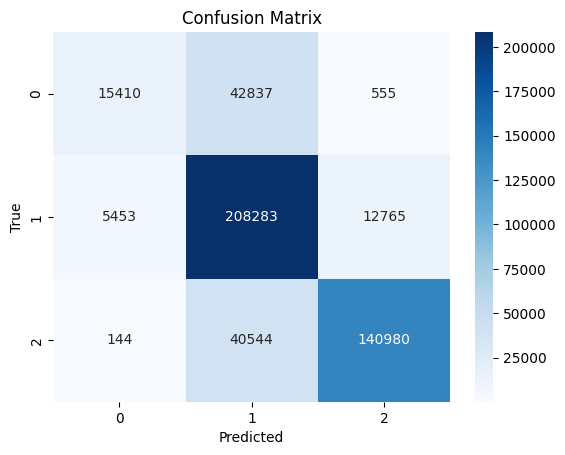

In [228]:
sns.heatmap(S_CLS_REG_BIN_OLD["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## NEW_SPLIT

### S_NEW_CLS_REG

In [662]:
S_REG_CLS_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_val_preds.npz"))
S_REG_CLS_BIN_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_val_preds.npz"), bin_regression_for_classification=True)

In [663]:
print(S_REG_CLS_NEW["pearson_r"]), print(S_REG_CLS_NEW["mean_absolute_error"]), print(S_REG_CLS_NEW["r2_score"])

PearsonRResult(statistic=np.float32(0.8321764), pvalue=np.float64(0.0))
0.38106024265289307
0.6904641389846802


(None, None, None)

In [235]:
print(S_REG_CLS_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.6221    0.4840    0.5444     61277
           1     0.7603    0.8444    0.8001    233447
           2     0.8787    0.8225    0.8497    190887

    accuracy                         0.7903    485611
   macro avg     0.7537    0.7170    0.7314    485611
weighted avg     0.7894    0.7903    0.7873    485611



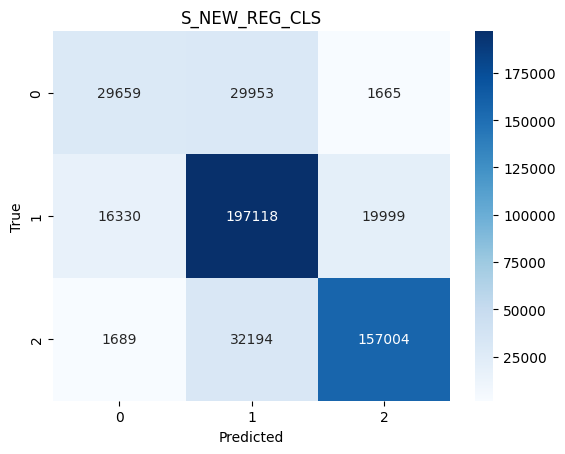

In [239]:
sns.heatmap(S_REG_CLS_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_REG_CLS')
plt.show()

In [240]:
print(S_REG_CLS_BIN_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.7140    0.2709    0.3928     61277
           1     0.7031    0.9262    0.7994    233447
           2     0.9280    0.7529    0.8313    190887

    accuracy                         0.7754    485611
   macro avg     0.7817    0.6500    0.6745    485611
weighted avg     0.7929    0.7754    0.7606    485611



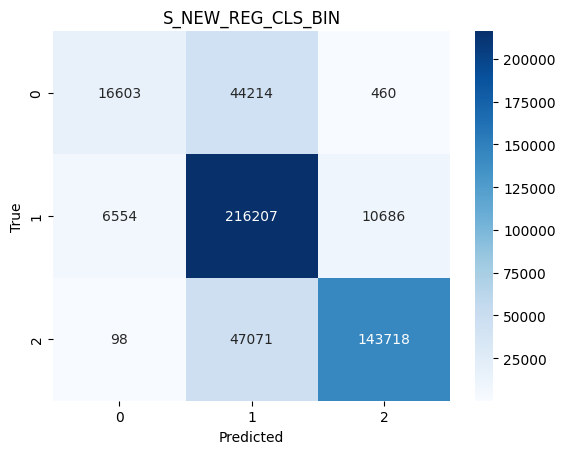

In [241]:
sns.heatmap(S_REG_CLS_BIN_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_REG_CLS_BIN')
plt.show()

### S_NEW_REG

In [249]:
# adding the masked_cls_targets since in older version they were not saved
cls_targets = np.load("../data/it4/it4_S_reg_cls_protT5_setnew_val_preds.npz")
s_reg_old = dict(np.load("../data/it4/it4_S_reg_protT5_setnew_val_preds.npz"))
s_reg_old["cls_targets"] = cls_targets["cls_targets"]
s_reg_old["masked_cls_targets"] = cls_targets["masked_cls_targets"]
np.savez("../data/it4/it4_S_reg_protT5_setnew_val_preds_2.npz", **s_reg_old)

In [660]:
S_REG_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_protT5_setnew_val_preds_2.npz"), bin_regression_for_classification=True)

In [661]:
print(S_REG_NEW["pearson_r"]), print(S_REG_NEW["mean_absolute_error"]), print(S_REG_NEW["r2_score"])

PearsonRResult(statistic=np.float32(0.8359599), pvalue=np.float64(0.0))
0.37038958072662354
0.6981375217437744


(None, None, None)

In [517]:
print(S_REG_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.7171    0.2758    0.3984     61277
           1     0.7162    0.9060    0.8000    233447
           2     0.9025    0.7884    0.8416    190887

    accuracy                         0.7802    485611
   macro avg     0.7786    0.6567    0.6800    485611
weighted avg     0.7896    0.7802    0.7657    485611



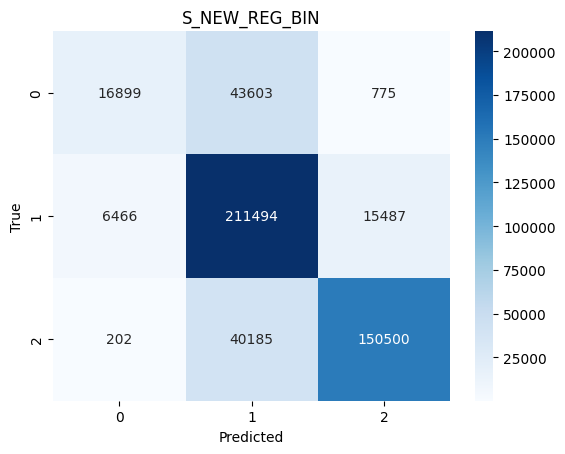

In [255]:
sns.heatmap(S_REG_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_REG_BIN')
plt.show()

### S_NEW_CLS

In [257]:
S_CLS_NEW = run_eval_metrics(np.load("../data/it4/it4_S_cls_protT5_setnew_val_preds.npz"), regression=False)

In [258]:
print(S_CLS_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.6407    0.4499    0.5286     61277
           1     0.7604    0.8448    0.8003    233447
           2     0.8679    0.8331    0.8501    190887

    accuracy                         0.7903    485611
   macro avg     0.7563    0.7092    0.7264    485611
weighted avg     0.7875    0.7903    0.7856    485611



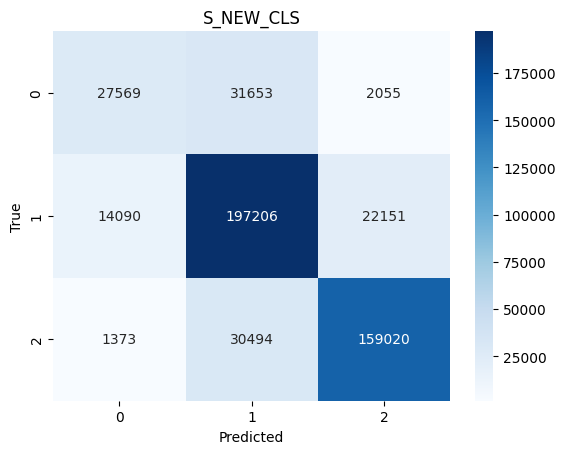

In [259]:
sns.heatmap(S_CLS_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS')
plt.show()

### S_NEW_CLS_REG_W

In [267]:
S_CLS_REG_W_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_ceweights_val_preds.npz"))
S_CLS_REG_BIN_W_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_ceweights_val_preds.npz"), bin_regression_for_classification=True)

In [268]:
print(S_CLS_REG_W_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.4065    0.8543    0.5509     61277
           1     0.8441    0.6117    0.7094    233447
           2     0.8572    0.8427    0.8499    190887

    accuracy                         0.7331    485611
   macro avg     0.7026    0.7696    0.7034    485611
weighted avg     0.7940    0.7331    0.7446    485611



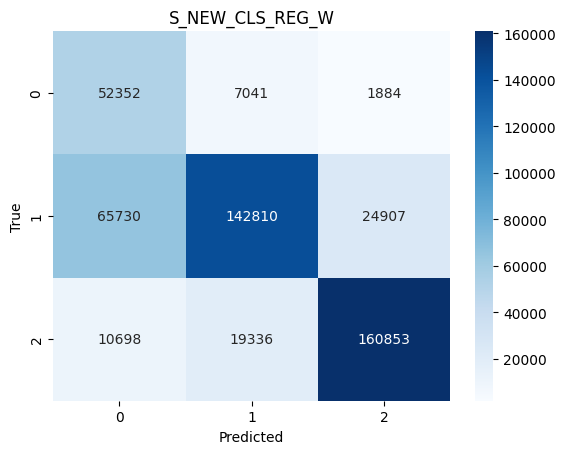

In [269]:
sns.heatmap(S_CLS_REG_W_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_W')
plt.show()

In [270]:
print(S_CLS_REG_W_NEW["spearman_r"]), print(S_CLS_REG_W_NEW["mean_absolute_error"]), print(S_CLS_REG_W_NEW["r2_score"])

0.8356887612438691
0.3800448179244995
0.6914382576942444


(None, None, None)

In [271]:
print(S_CLS_REG_BIN_W_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.7519    0.2479    0.3729     61277
           1     0.7047    0.9295    0.8017    233447
           2     0.9239    0.7624    0.8354    190887

    accuracy                         0.7778    485611
   macro avg     0.7935    0.6466    0.6700    485611
weighted avg     0.7968    0.7778    0.7608    485611



### S_NEW_CLS_REG_LORAQK

In [664]:
S_CLS_REG_QK_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraQK_val_preds.npz"))
S_CLS_REG_BIN_QK_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraQK_val_preds.npz"), bin_regression_for_classification=True)

In [665]:
print(S_CLS_REG_QK_NEW["pearson_r"]), print(S_CLS_REG_QK_NEW["mean_absolute_error"]), print(S_CLS_REG_QK_NEW["r2_score"])

PearsonRResult(statistic=np.float32(0.84203887), pvalue=np.float64(0.0))
0.3615846633911133
0.7086412906646729


(None, None, None)

In [274]:
print(S_CLS_REG_QK_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.6386    0.5162    0.5709     61277
           1     0.7794    0.8280    0.8030    233447
           2     0.8614    0.8487    0.8550    190887

    accuracy                         0.7968    485611
   macro avg     0.7598    0.7310    0.7430    485611
weighted avg     0.7939    0.7968    0.7942    485611



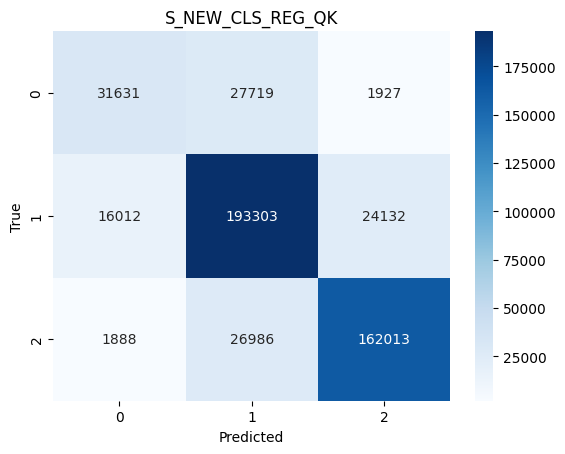

In [276]:
sns.heatmap(S_CLS_REG_QK_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_QK')
plt.show()

In [277]:
print(S_CLS_REG_BIN_QK_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.7283    0.3434    0.4667     61277
           1     0.7227    0.9082    0.8049    233447
           2     0.9117    0.7802    0.8409    190887

    accuracy                         0.7866    485611
   macro avg     0.7876    0.6773    0.7042    485611
weighted avg     0.7977    0.7866    0.7764    485611



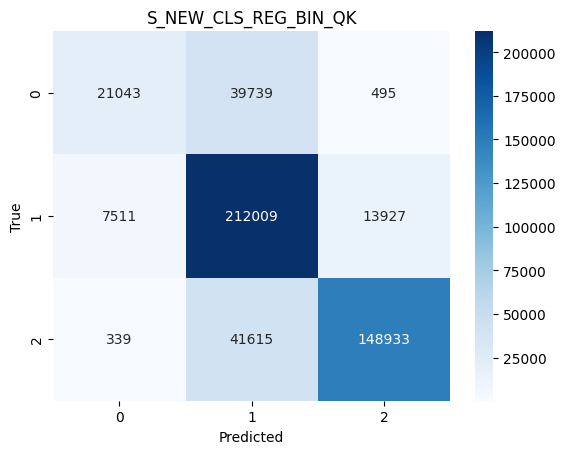

In [278]:
sns.heatmap(S_CLS_REG_BIN_QK_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_BIN_QK')
plt.show()

### S_NEW_CLS_REG_LORAALL

In [2]:
S_CLS_REG_ALL_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_val_preds.npz"))
S_CLS_REG_BIN_ALL_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_val_preds.npz"), bin_regression_for_classification=True)

In [8]:
np.bincount(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_val_preds.npz")["masked_cls_preds"])

array([ 49194, 251190, 185227])

Text(0.5, 0, 'Predicted Frustration Scores. Validation set')

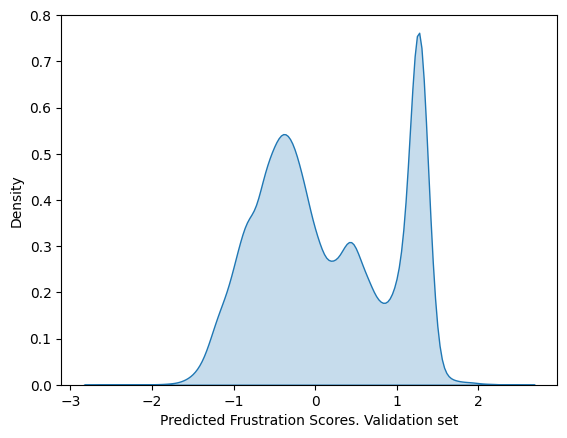

In [11]:
sns.kdeplot(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_val_preds.npz")["masked_regr_preds"], 
            fill=True)
plt.xlabel("Predicted Frustration Scores. Validation set")

In [3]:
print(S_CLS_REG_ALL_NEW["pearson_r"]), print(S_CLS_REG_ALL_NEW["mean_absolute_error"]), print(S_CLS_REG_ALL_NEW["r2_score"])

PearsonRResult(statistic=np.float32(0.8474142), pvalue=np.float64(0.0))
0.3480432331562042
0.7179757356643677


(None, None, None)

In [4]:
print(S_CLS_REG_ALL_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.6559    0.5265    0.5841     61277
           1     0.7784    0.8376    0.8069    233447
           2     0.8691    0.8433    0.8560    190887

    accuracy                         0.8006    485611
   macro avg     0.7678    0.7358    0.7490    485611
weighted avg     0.7986    0.8006    0.7981    485611



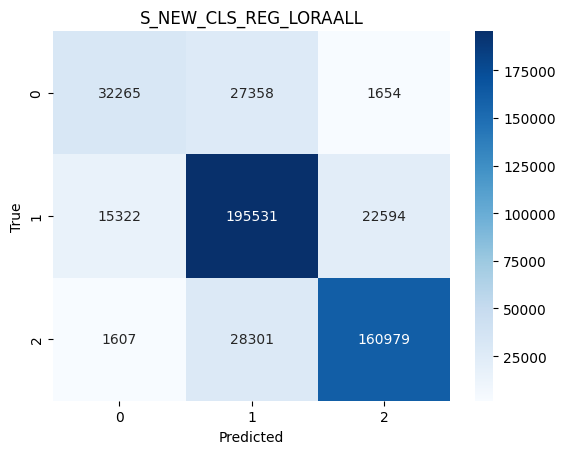

In [282]:
sns.heatmap(S_CLS_REG_ALL_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_LORAALL')
plt.show()

In [283]:
print(S_CLS_REG_BIN_ALL_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.7425    0.3730    0.4965     61277
           1     0.7326    0.9078    0.8108    233447
           2     0.9113    0.7905    0.8466    190887

    accuracy                         0.7942    485611
   macro avg     0.7955    0.6904    0.7180    485611
weighted avg     0.8041    0.7942    0.7853    485611



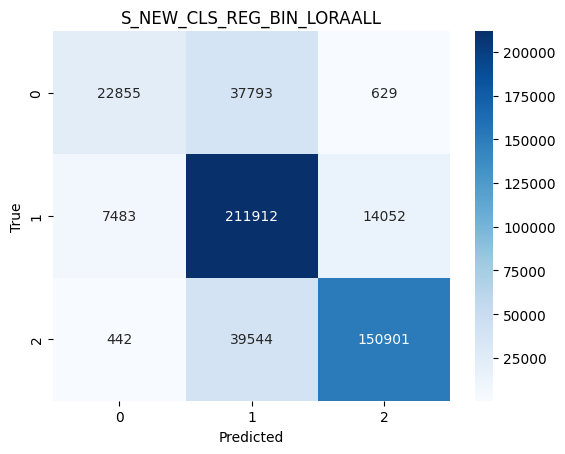

In [288]:
sns.heatmap(S_CLS_REG_BIN_ALL_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_BIN_LORAALL')
plt.show()

### S_NEW_CLS_REG_LORAALL_CE

In [289]:
S_CLS_REG_ALL_W_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_ceweight_val_preds.npz"))
S_CLS_REG_BIN_ALL_W_NEW = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_ceweight_val_preds.npz"), bin_regression_for_classification=True)

In [290]:
print(S_CLS_REG_ALL_W_NEW["spearman_r"]), print(S_CLS_REG_ALL_W_NEW["mean_absolute_error"]), print(S_CLS_REG_ALL_W_NEW["r2_score"])

0.8476952422882388
0.3550918996334076
0.713165283203125


(None, None, None)

In [291]:
print(S_CLS_REG_ALL_W_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.4666    0.8089    0.5918     61277
           1     0.8431    0.6645    0.7432    233447
           2     0.8421    0.8620    0.8519    190887

    accuracy                         0.7603    485611
   macro avg     0.7173    0.7785    0.7290    485611
weighted avg     0.7952    0.7603    0.7669    485611



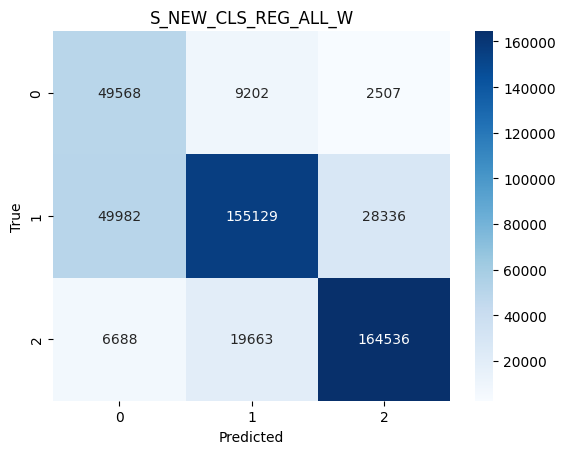

In [292]:
sns.heatmap(S_CLS_REG_ALL_W_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_ALL_W')
plt.show()

In [233]:
print(S_CLS_REG_LORAALL_CE_NEW["spearman_r"]), print(S_CLS_REG_LORAALL_CE_NEW["mean_absolute_error"]), print(S_CLS_REG_LORAALL_CE_NEW["r2_score"])

0.8476952422882388
0.3550918996334076
0.713165283203125


(None, None, None)

### S_NEW_CLS_REG_LORAALL_CE PROST

In [324]:
S_CLS_REG_ALL_W_NEW_PROST = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_prostT5_setnew_loraAll_ceweight_val_preds.npz"))
S_CLS_REG_BIN_ALL_W_NEW_PROST = run_eval_metrics(np.load("../data/it4/it4_S_reg_cls_prostT5_setnew_loraAll_ceweight_val_preds.npz"), bin_regression_for_classification=True)

In [325]:
print(S_CLS_REG_ALL_W_NEW_PROST["spearman_r"]), print(S_CLS_REG_ALL_W_NEW_PROST["mean_absolute_error"]), print(S_CLS_REG_ALL_W_NEW_PROST["r2_score"])

0.8554087834485783
0.344228595495224
0.7282989025115967


(None, None, None)

In [326]:
print(S_CLS_REG_ALL_W_NEW_PROST["cls_report"])

              precision    recall  f1-score   support

           0     0.4661    0.8269    0.5962     61277
           1     0.8449    0.6622    0.7425    233447
           2     0.8512    0.8648    0.8579    190887

    accuracy                         0.7626    485611
   macro avg     0.7207    0.7846    0.7322    485611
weighted avg     0.7996    0.7626    0.7694    485611



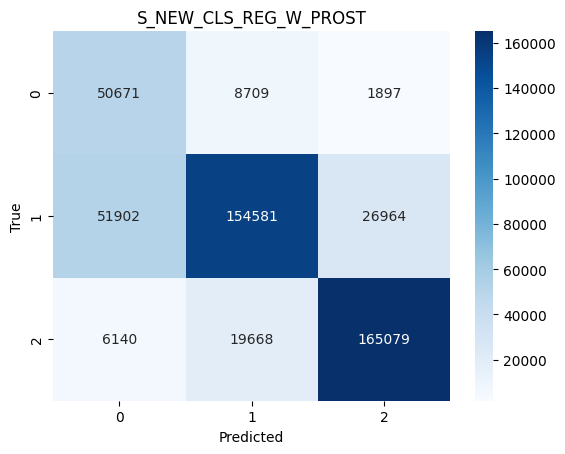

In [327]:
sns.heatmap(S_CLS_REG_ALL_W_NEW_PROST["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('S_NEW_CLS_REG_W_PROST')
plt.show()

### NEW_JOINT_FTALL_CE

In [342]:
CNN_JOINT_FTALL_CE_NEW = run_eval_metrics(np.load("../data/it4/it4_joint_ftall_ce_test_preds.npz"))

In [343]:
print(CNN_JOINT_FTALL_CE_NEW["spearman_r"]), print(CNN_JOINT_FTALL_CE_NEW["mean_absolute_error"]), print(CNN_JOINT_FTALL_CE_NEW["r2_score"])

0.8610414602596557
0.33346396684646606
0.7369974255561829


(None, None, None)

In [ ]:
print(CNN_JOINT_FTALL_CE_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.4683    0.8622    0.6069   1225372
           1     0.8628    0.6808    0.7611   4764618
           2     0.8647    0.8588    0.8617   3746359

    accuracy                         0.7721   9736349
   macro avg     0.7319    0.8006    0.7432   9736349
weighted avg     0.8139    0.7721    0.7804   9736349



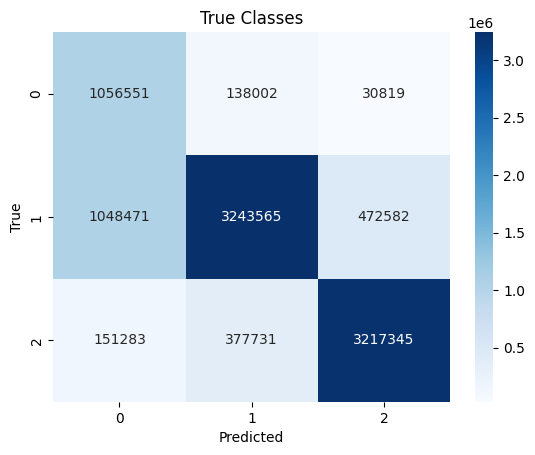

In [345]:
sns.heatmap(CNN_JOINT_FTALL_CE_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('True Classes')
plt.show()

In [ ]:
CNN_JOINT_FTALL_CE_NEW["preds_dict"]["masks"]

(47765, 512)

In [ ]:
pp_spearman = np.array([spearmanr(targets[m], preds[m])[0] 
                        for targets, preds, m in 
                        zip(CNN_JOINT_FTALL_CE_NEW["preds_dict"]["regr_targets"], 
                            CNN_JOINT_FTALL_CE_NEW["preds_dict"]["regr_preds"], 
                            CNN_JOINT_FTALL_CE_NEW["preds_dict"]["masks"])
                        if spearmanr(targets[m], preds[m])[1] < 0.05])

In [659]:
pp_spearman.shape

(46609,)

In [658]:
pp_spearman[~np.isnan(pp_spearman)].mean(), pp_spearman[~np.isnan(pp_spearman)].std()

(np.float64(0.8547596816400953), np.float64(0.042962405572483195))

<Axes: ylabel='Count'>

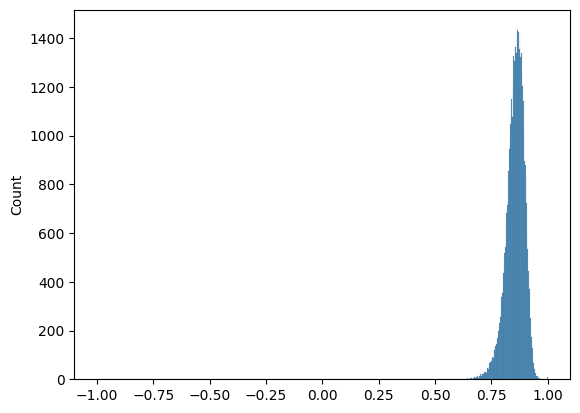

In [694]:
sns.histplot(pp_spearman[~np.isnan(pp_spearman)])

### NEW_JOINT_LORAALL_CE_NODROPOUT

In [781]:
data = np.load("../data/it4/it4_joint_ftAll_Ce_noDropout_test_preds.npz")
data = {key: data[key] for key in data.files}
data["masked_cls_preds"] = data["masked_cls_preds"].reshape(-1, 3).argmax(axis=1)

In [786]:
CNN_JOINT_FTALL_CE_ND_NEW = run_eval_metrics(data)

In [772]:
data = np.load("../data/it4/it4_joint_ftAll_Ce_noDropout_test_preds.npz")

In [774]:
data["masked_cls_preds"].shape, data["masked_cls_targets"].shape

((29209047,), (9736349,))

In [780]:
data["masked_cls_preds"].reshape(-1, 3).argmax(axis=1)

array([1, 1, 1, ..., 1, 0, 2], shape=(9736349,))

In [777]:
data["masked_cls_preds"].reshape(-1, 3).shape, data["masked_cls_targets"].shape

((9736349, 3), (9736349,))

In [787]:
print(CNN_JOINT_FTALL_CE_ND_NEW["spearman_r"]), print(CNN_JOINT_FTALL_CE_ND_NEW["mean_absolute_error"]), print(CNN_JOINT_FTALL_CE_ND_NEW["r2_score"])

SignificanceResult(statistic=np.float64(0.8628421127521652), pvalue=np.float64(0.0))
0.3251551687717438
0.737295925617218


(None, None, None)

In [788]:
print(CNN_JOINT_FTALL_CE_ND_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.4938    0.8374    0.6213   1225372
           1     0.8605    0.6990    0.7714   4764618
           2     0.8567    0.8663    0.8615   3746359

    accuracy                         0.7808   9736349
   macro avg     0.7370    0.8009    0.7514   9736349
weighted avg     0.8129    0.7808    0.7872   9736349



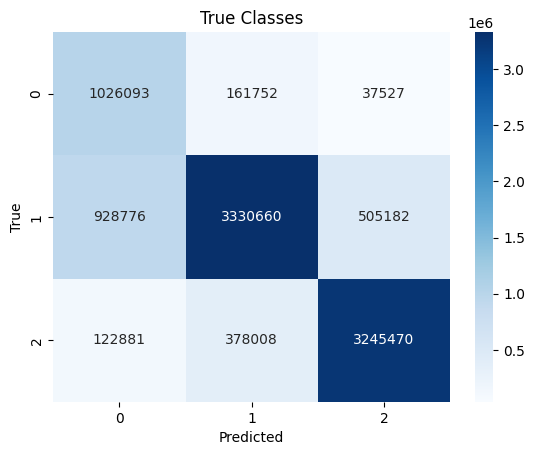

In [789]:
sns.heatmap(CNN_JOINT_FTALL_CE_ND_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('True Classes')
plt.show()

### NEW_JOINT_LORAALL_LOWCE_NODROPOUT

In [790]:
data = np.load("../data/it4/it4_joint_ftAll_lowCe_noDropout_test_preds.npz")
data = {key: data[key] for key in data.files}
data["masked_cls_preds"] = data["masked_cls_preds"].reshape(-1, 3).argmax(axis=1)

In [791]:
CNN_JOINT_FTALL_LCE_ND_NEW = run_eval_metrics(data)

In [792]:
print(CNN_JOINT_FTALL_LCE_ND_NEW["spearman_r"]), print(CNN_JOINT_FTALL_LCE_ND_NEW["mean_absolute_error"]), print(CNN_JOINT_FTALL_LCE_ND_NEW["r2_score"])

SignificanceResult(statistic=np.float64(0.8604108555256941), pvalue=np.float64(0.0))
0.3296137750148773
0.7347691059112549


(None, None, None)

In [793]:
print(CNN_JOINT_FTALL_LCE_ND_NEW["cls_report"])

              precision    recall  f1-score   support

           0     0.4768    0.8576    0.6128   1225372
           1     0.8578    0.6944    0.7675   4764618
           2     0.8689    0.8524    0.8605   3746359

    accuracy                         0.7757   9736349
   macro avg     0.7345    0.8014    0.7470   9736349
weighted avg     0.8141    0.7757    0.7838   9736349



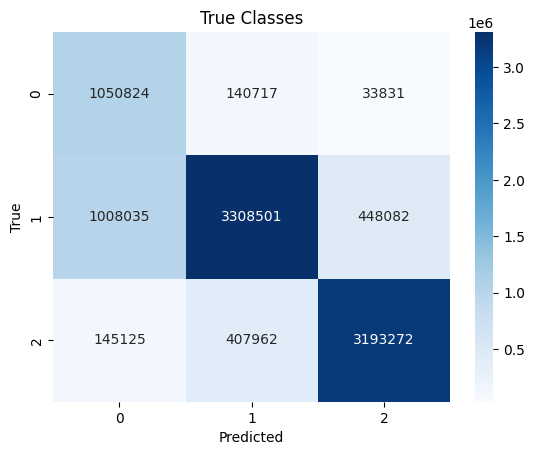

In [794]:
sns.heatmap(CNN_JOINT_FTALL_LCE_ND_NEW["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title('True Classes')
plt.show()

### Entropy

In [3]:
data = np.load("../data/it4/it4_joint_ftall_ce_test_mc_dropout_preds.npz")
data.keys()

KeysView(NpzFile '../data/it4/it4_joint_ftall_ce_test_mc_dropout_preds.npz' with keys: full_seqs, masks, regr_preds, cls_preds, regr_targets...)

In [4]:
padded_seqs = []
for seq in data["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
seq_array = np.array([list(seq) for seq in padded_seqs])
masked_residues = seq_array[data["masks"]]
masked_residues.shape

(512158,)

In [5]:
data["masked_cls_preds"].shape

(1536474,)

In [11]:
#reshape because of flattening in testing :( argmax here axis 1
masked_cls_preds_logits = softmax(data["masked_cls_preds"].reshape(-1, 3), axis=-1)
masked_cls_preds = masked_cls_preds_logits.argmax(axis=1)
masked_cls_preds_logits.shape, masked_cls_preds.shape

((512158, 3), (512158,))

In [12]:
rep = classification_report(data["masked_cls_targets"], masked_cls_preds, digits=4)
print(rep)

              precision    recall  f1-score   support

           0     0.4449    0.8609    0.5866     63324
           1     0.8608    0.6663    0.7512    250624
           2     0.8705    0.8591    0.8648    198210

    accuracy                         0.7650    512158
   macro avg     0.7254    0.7954    0.7342    512158
weighted avg     0.8131    0.7650    0.7748    512158



In [13]:
entropies = entropy(masked_cls_preds_logits, axis=-1)
entropies_norm = entropies / np.log(3)
entropies.shape, entropies_norm.shape

((512158,), (512158,))

In [14]:
correct_mask = masked_cls_preds == data["masked_cls_targets"]
correct_mask

array([False, False,  True, ...,  True,  True,  True], shape=(512158,))

In [15]:
correct_cls0_mask = (data["masked_cls_targets"] == 0) & correct_mask
correct_cls1_mask = (data["masked_cls_targets"] == 1) & correct_mask
correct_cls2_mask = (data["masked_cls_targets"] == 2) & correct_mask
incorrect_cls0_mask = (data["masked_cls_targets"] == 0) & ~correct_mask
incorrect_cls1_mask = (data["masked_cls_targets"] == 1) & ~correct_mask
incorrect_cls2_mask = (data["masked_cls_targets"] == 2) & ~correct_mask

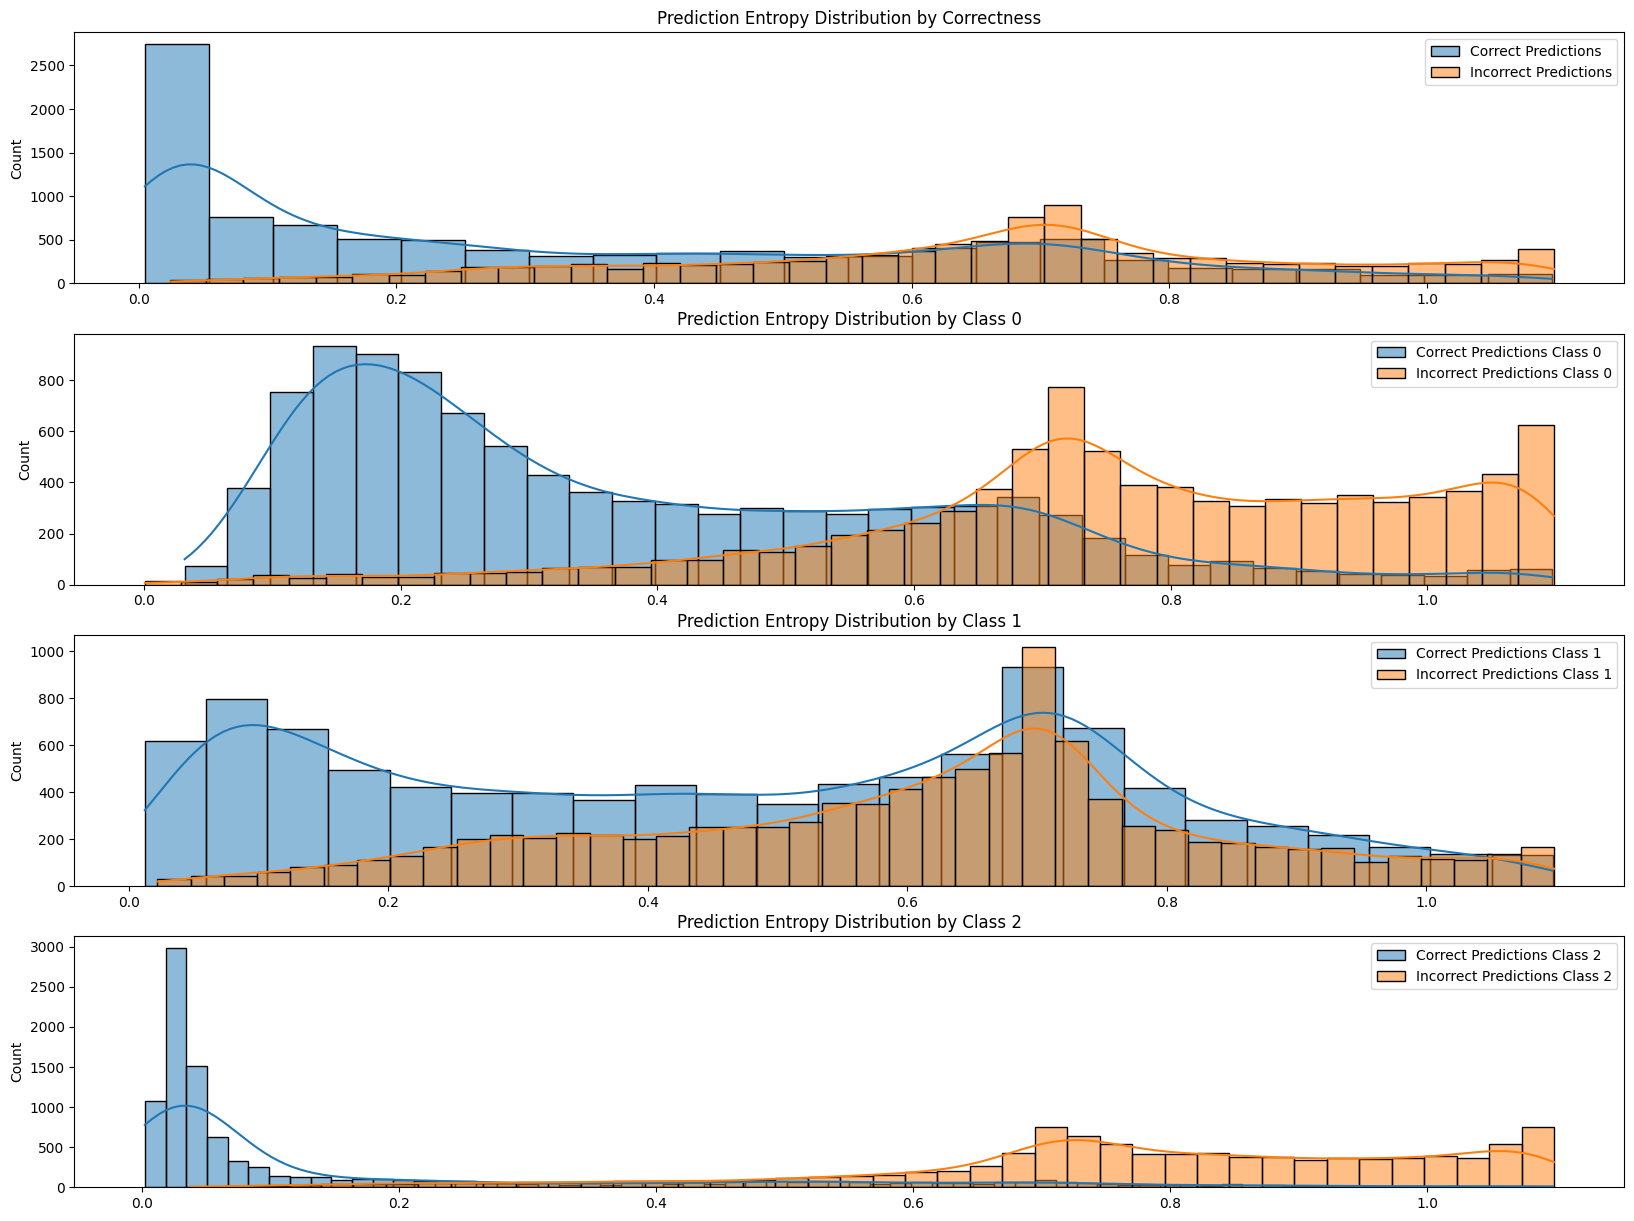

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(20, 15))

sns.histplot(entropies[correct_mask][:10000], kde=True, label='Correct Predictions', ax=axes[0])
sns.histplot(entropies[~correct_mask][:10000], kde=True, label='Incorrect Predictions', ax=axes[0])
axes[0].legend()
axes[0].set_title('Prediction Entropy Distribution by Correctness')

for cls in range(3):
    sns.histplot(entropies[(data["masked_cls_targets"] == cls) & correct_mask][:10000], kde=True, label=f'Correct Predictions Class {cls}', ax=axes[cls+1])
    sns.histplot(entropies[(data["masked_cls_targets"] == cls) & ~correct_mask][:10000], kde=True, label=f'Incorrect Predictions Class {cls}', ax=axes[cls+1])
    axes[cls+1].legend()
    axes[cls+1].set_title(f'Prediction Entropy Distribution by Class {cls}')
plt.show()

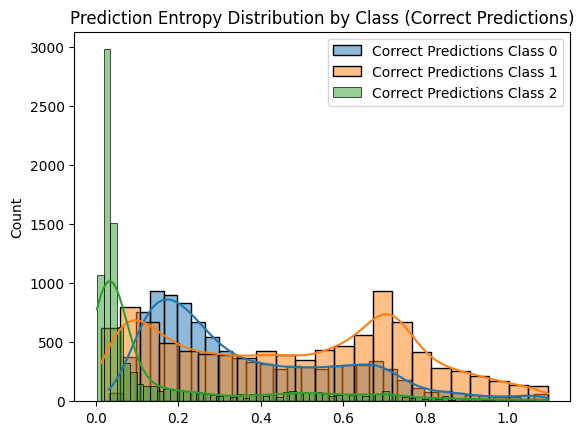

In [681]:
sns.histplot(entropies[correct_cls0_mask][:10000], kde=True, label='Correct Predictions Class 0')
sns.histplot(entropies[correct_cls1_mask][:10000], kde=True, label='Correct Predictions Class 1')
sns.histplot(entropies[correct_cls2_mask][:10000], kde=True, label='Correct Predictions Class 2')
plt.legend()
plt.title('Prediction Entropy Distribution by Class (Correct Predictions)')
plt.show()

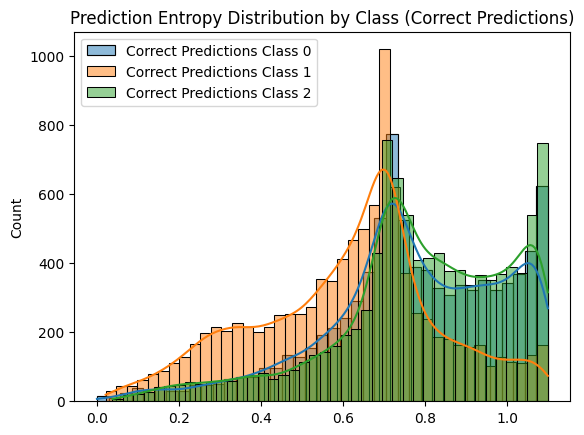

In [683]:
sns.histplot(entropies[incorrect_cls0_mask][:10000], kde=True, label='Correct Predictions Class 0')
sns.histplot(entropies[incorrect_cls1_mask][:10000], kde=True, label='Correct Predictions Class 1')
sns.histplot(entropies[incorrect_cls2_mask][:10000], kde=True, label='Correct Predictions Class 2')
plt.legend()
plt.title('Prediction Entropy Distribution by Class (Correct Predictions)')
plt.show()

In [25]:
mask.sum()

np.int64(108624)

In [ ]:
N = masked_cls_preds.shape[0]

precisions = []
recalls = []
coverages = []
accepted_counts = []
for t in np.arange(0.05, 1.05, 0.05):
        mask = entropies_norm <= t
        rep_t = classification_report(data["masked_cls_targets"][mask], masked_cls_preds[mask], digits=4)
        print(rep_t)
        k = mask.sum()
        accepted_counts.append(int(k))
        coverage = k / float(N)
        coverages.append(coverage)
        if k == 0:
            precisions.append(np.nan)   # no accepted samples
            recalls.append(0.0)
        else:
            n_correct = correct_mask[mask].sum()
            prec = n_correct / float(k) # precision = TP / (TP + FP)
            rec = n_correct / float(N) # recall = TP / (TP + FN)
            precisions.append(float(prec))
            recalls.append(float(rec))

              precision    recall  f1-score   support

           0     0.8777    0.9013    0.8894       223
           1     0.9985    0.9552    0.9764     13404
           2     0.9938    0.9998    0.9968     94997

    accuracy                         0.9941    108624
   macro avg     0.9567    0.9521    0.9542    108624
weighted avg     0.9941    0.9941    0.9941    108624



In [ ]:
# Inputs you must already have:
# masked_cls_preds: (N,) predicted class labels
# masked_cls_true:  (N,) true class labels
# correct_mask:     (N,) boolean array -> masked_cls_preds == masked_cls_true
# entropies_norm:   (N,) normalized entropy in [0,1]

N = masked_cls_preds.shape[0]
classes = [0, 1, 2]

# global metrics
precisions = []
recalls = []
coverages = []
accepted_counts = []

# per-class metrics
precisions_per_class = {c: [] for c in classes}
recalls_per_class = {c: [] for c in classes}

for t in np.arange(0.05, 1.05, 0.05):
    mask = entropies_norm <= t # accepted samples
    k = mask.sum() # number of accepted samples
    accepted_counts.append(int(k))
    coverage = k / float(N)
    coverages.append(coverage)

    if k == 0:
        # global
        precisions.append(np.nan)
        recalls.append(0.0)

        # per class: append NaN
        for c in classes:
            precisions_per_class[c].append(np.nan)
            recalls_per_class[c].append(0.0)
        continue

    # ---------- Global selective precision & recall ----------
    correct = correct_mask.astype(int)

    prec_global = correct[mask].sum() / float(k)
    rec_global = correct[mask].sum() / float(N)

    precisions.append(float(prec_global))
    recalls.append(float(rec_global))

    # ---------- Per-class selective precision & recall ----------
    preds = masked_cls_preds
    truth = data["masked_cls_targets"]

    for c in classes:
        # class-specific mask restricted to accepted set
        mask_c = mask & (preds == c)
        k_c = mask_c.sum()

        if k_c == 0:
            # Nobody predicted class c among accepted samples
            precisions_per_class[c].append(np.nan)
        else:
            # precision_c = correct predictions of c / predictions of c
            prec_c = np.sum((preds == c) & (truth == c) & mask) / float(k_c)
            precisions_per_class[c].append(float(prec_c))

        # recall_c = correct predictions of c among accepted samples / total true class c in full dataset
        total_true_c = np.sum(truth == c)
        if total_true_c == 0:
            # no real instances of class c in dataset
            recalls_per_class[c].append(np.nan)
        else:
            rec_c = np.sum((preds == c) & (truth == c) & mask) / float(total_true_c)
            recalls_per_class[c].append(float(rec_c))


In [58]:
mask = entropies_norm <= 0.5

In [59]:
print(classification_report(data["masked_cls_targets"][mask], masked_cls_preds[mask]))

              precision    recall  f1-score   support

           0       0.64      0.97      0.77     39441
           1       0.97      0.77      0.85    119936
           2       0.95      0.98      0.96    148340

    accuracy                           0.89    307717
   macro avg       0.85      0.90      0.86    307717
weighted avg       0.92      0.89      0.90    307717



In [61]:
recalls_per_class[0]

[0.0031741519802918326,
 0.04702798307118944,
 0.14424230939296317,
 0.2465573874044596,
 0.33743920156654666,
 0.40990777588276167,
 0.4666003411028994,
 0.514133661802792,
 0.5586191649295685,
 0.6028204156401996,
 0.646753205735582,
 0.693481144589729,
 0.7446307876950288,
 0.779483292274651,
 0.7982913271429474,
 0.8145568820668309,
 0.8294169667108837,
 0.8402501421262081,
 0.8496936390625986,
 0.8608584422967596]

In [54]:
np.array(recalls_per_class[0]) + np.array(recalls_per_class[1]) + np.array(recalls_per_class[2])

array([0.53344633, 0.71848788, 0.89694838, 1.06012047, 1.20392647,
       1.3252075 , 1.42769762, 1.51964913, 1.61035902, 1.70179878,
       1.7956194 , 1.89776444, 2.02897002, 2.1300541 , 2.19207481,
       2.24248485, 2.28697489, 2.32307921, 2.35337462, 2.38630452])

In [55]:
recalls_per_class["macro"] = (np.array(recalls_per_class[0]) + np.array(recalls_per_class[1]) + np.array(recalls_per_class[2])) / 3.0
precisions_per_class["macro"] = (np.array(precisions_per_class[0]) + np.array(precisions_per_class[1]) + np.array(precisions_per_class[2])) / 3.0

In [56]:
recalls_per_class["macro"]

array([0.17781544, 0.23949596, 0.29898279, 0.35337349, 0.40130882,
       0.44173583, 0.47589921, 0.50654971, 0.53678634, 0.56726626,
       0.5985398 , 0.63258815, 0.67632334, 0.71001803, 0.7306916 ,
       0.74749495, 0.76232496, 0.77435974, 0.78445821, 0.79543484])

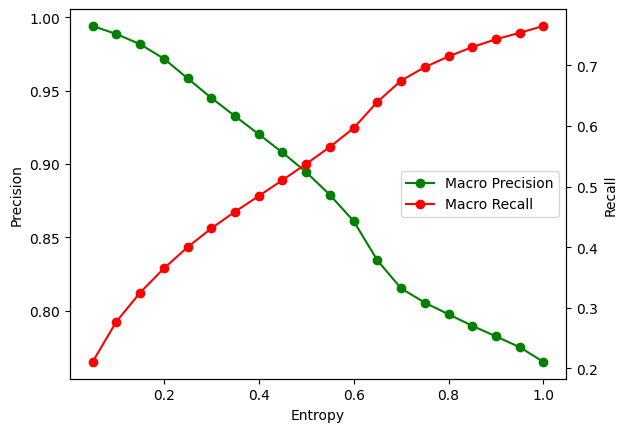

In [24]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(np.arange(0.05,1.05,0.05), precisions, 'o-', color="green", label="Macro Precision")
ax2.plot(np.arange(0.05,1.05,0.05), recalls, 'o-', color="red", label="Macro Recall")

ax1.set_xlabel('Entropy')
ax1.set_ylabel('Precision',)
ax2.set_ylabel('Recall',)

lns = [ax1.lines[0], ax2.lines[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

plt.show()

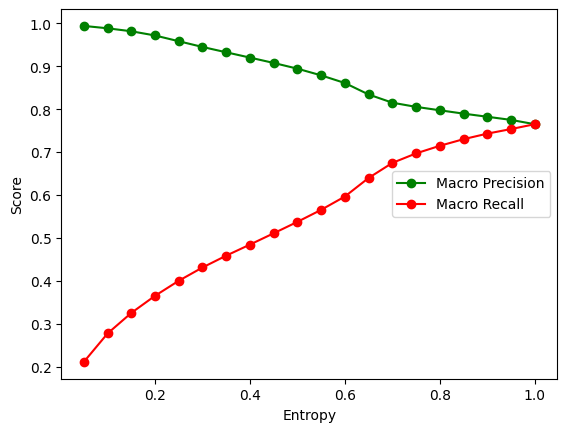

In [25]:
fig, ax1 = plt.subplots()

ax1.plot(np.arange(0.05,1.05,0.05), precisions, 'o-', color="green", label="Macro Precision")
ax1.plot(np.arange(0.05,1.05,0.05), recalls, 'o-', color="red", label="Macro Recall")

ax1.set_xlabel('Entropy')
ax1.set_ylabel('Score')
ax1.legend(loc='center right')

plt.show()

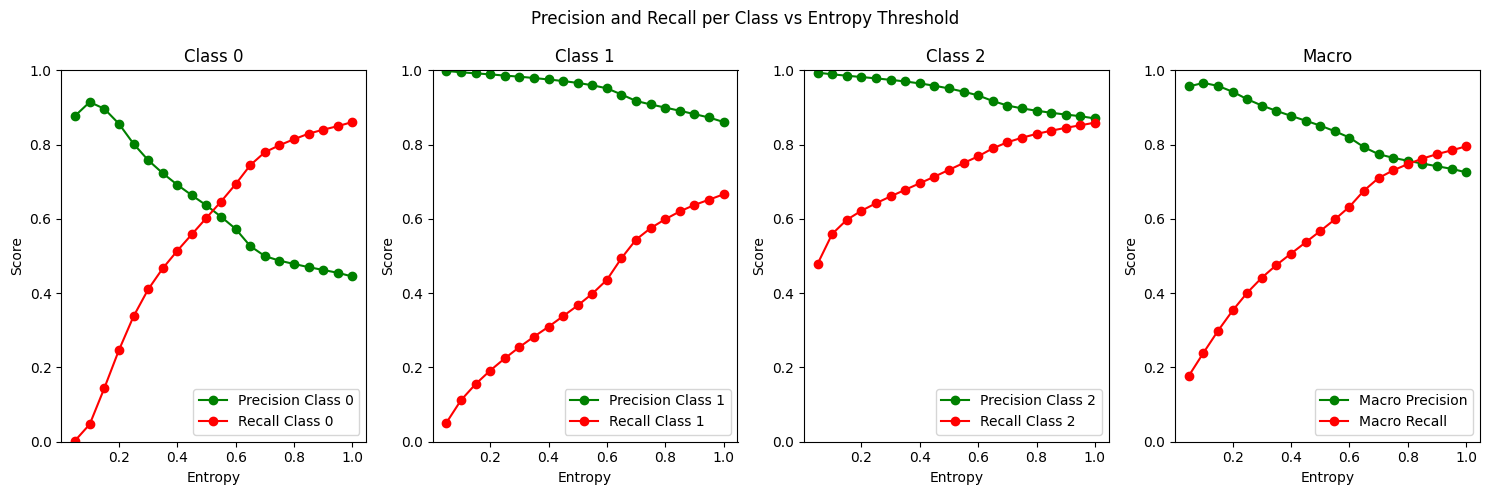

In [57]:
# fig with 3 subplots
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))

for i in range(3):
    cls = i
    ax[i].plot(np.arange(0.05,1.05,0.05), precisions_per_class[cls], 'o-', color="green", label=f"Precision Class {cls}")
    ax[i].plot(np.arange(0.05,1.05,0.05), recalls_per_class[cls], 'o-', color="red", label=f"Recall Class {cls}")
    ax[i].set_ylim(0, 1)
    ax[i].set_xlabel('Entropy')
    ax[i].set_ylabel('Score')
    ax[i].set_title(f'Class {cls}')
    ax[i].legend(loc='lower right')

ax[3].plot(np.arange(0.05,1.05,0.05), precisions_per_class["macro"], 'o-', color="green", label="Macro Precision")
ax[3].plot(np.arange(0.05,1.05,0.05), recalls_per_class["macro"], 'o-', color="red", label="Macro Recall")
ax[3].set_ylim(0, 1)
ax[3].set_xlabel('Entropy')
ax[3].set_ylabel('Score')
ax[3].set_title('Macro')
ax[3].legend(loc='lower right')

plt.suptitle('Precision and Recall per Class vs Entropy Threshold')
plt.tight_layout()
plt.show()

In [ ]:
macro_precision_list = []
macro_recall_list = []
macro_f1_list = []
support_list = []
for thresh in np.arange(0.05, 1.05, 0.05):
    t_mask = entropies <= thresh
    
    rep = classification_report(data["masked_cls_targets"][t_mask], masked_cls_preds.argmax(axis=-1)[t_mask], output_dict=True)
    macro_precision_list.append(rep["macro avg"]["precision"])
    macro_recall_list.append(rep["macro avg"]["recall"])
    support_list.append(rep["macro avg"]["support"])
    macro_f1_list.append(rep["macro avg"]["f1-score"])
macro_f1_list = np.array(macro_f1_list)
macro_precision_list = np.array(macro_precision_list)
macro_recall_list = np.array(macro_recall_list)
support_list = np.array(support_list)

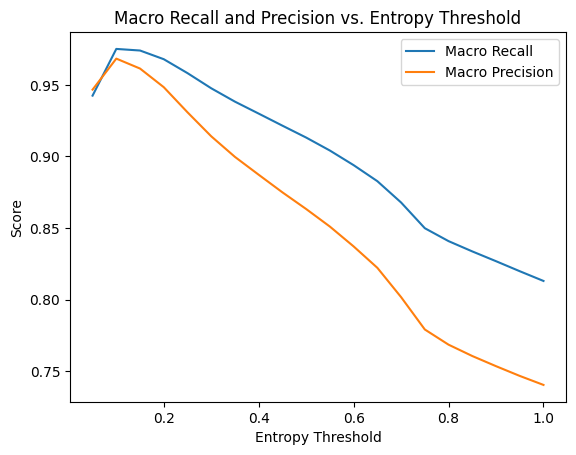

In [834]:
sns.lineplot(x=np.arange(0.05,1.05,0.05), y=macro_recall_list, label='Macro Recall')
sns.lineplot(x=np.arange(0.05,1.05,0.05), y=macro_precision_list, label='Macro Precision')
plt.title('Macro Recall and Precision vs. Entropy Threshold')
plt.xlabel('Entropy Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

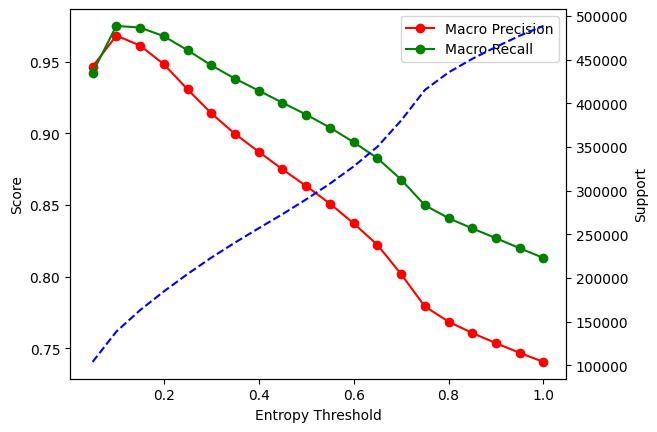

In [848]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(np.arange(0.05,1.05,0.05), macro_precision_list, 'o-', color="red", label="Macro Precision")
ax1.plot(np.arange(0.05,1.05,0.05), macro_recall_list, 'o-', color="green", label="Macro Recall")
ax2.plot(np.arange(0.05,1.05,0.05), support_list, '--', color="blue", label="Support")

ax1.set_xlabel('Entropy Threshold')
ax1.set_ylabel('Score',)
ax2.set_ylabel('Support',)

ax1.legend(loc="upper right")
#ax2.legend(loc="upper right")

plt.show()

In [837]:
support_list

array([103711., 138404., 163024., 184429., 204394., 223175., 240440.,
       256887., 272989., 289976., 308006., 327718., 350260., 380306.,
       415326., 435464., 451052., 464716., 477549., 488755.])

In [841]:
entropies.max()

np.float32(1.098608)

### Z scores

In [1]:
with open('../data/frustration/reg_heuristic.json', 'r') as f:
    reg_dict = json.load(f)
with open('../data/frustration/cls_heuristic.json', 'r') as f:
    cls_dict = json.load(f)

NameError: name 'json' is not defined

In [ ]:
reg_dict["A"]

{'mean': 0.24633155516241328, 'std': 0.5921655729624687}

In [700]:
masked_residues

array(['R', 'Q', 'E', ..., 'V', 'L', 'V'], shape=(512158,), dtype='<U1')

In [702]:
masked_cls_preds.argmax(axis=-1)

array([2, 0, 0, ..., 2, 2, 2], shape=(512158,))

In [704]:
data["masked_regr_preds"]

array([ 1.0812225, -0.6781286, -1.0798095, ...,  1.3141543,  1.1676241,
        1.2493136], shape=(512158,), dtype=float32)

In [714]:
z_scores = []
for res, regr in zip(masked_residues, data["masked_regr_preds"]):
    mean = reg_dict[res]["mean"]
    std = reg_dict[res]["std"]
    z = (regr - mean) / std
    z_scores.append(z)
z_scores = np.array(z_scores)

<Axes: ylabel='Count'>

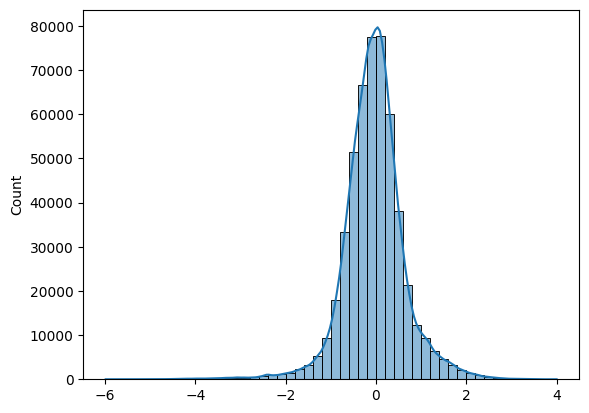

In [715]:
sns.histplot(z_scores, kde=True, bins=50)

<Axes: >

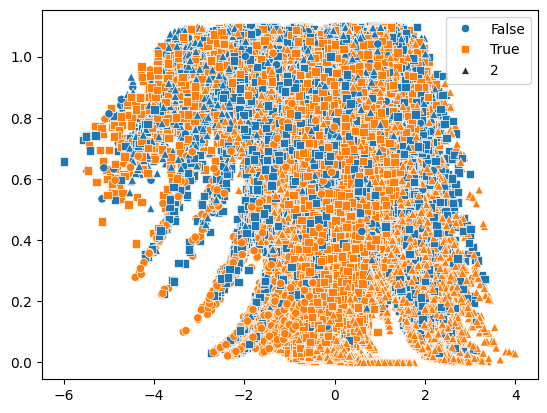

In [731]:
markers = {0: 'o', 1: 's', 2: '^'}
sns.scatterplot(x=z_scores, y=entropies, hue=correct_mask, style=data["masked_cls_targets"], markers=markers)

In [738]:
masked_regr_error.max(), masked_regr_error.min()

(np.float32(6.423), np.float32(7.8976154e-07))

In [744]:
masked_regr_error = np.abs(data["masked_regr_targets"] - data["masked_regr_preds"])
# cutoff at 3 for better color scale
masked_regr_error = np.clip(masked_regr_error, 0, 2)

<Axes: >

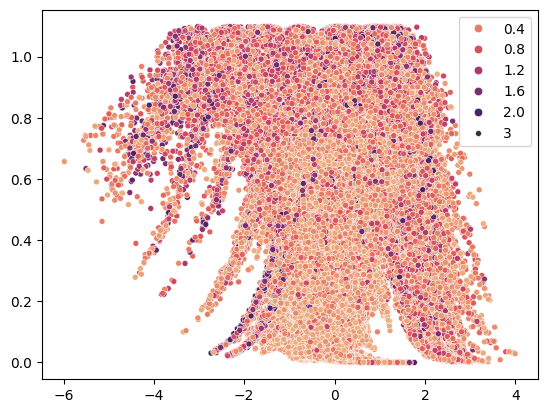

In [750]:
sns.scatterplot(x=z_scores, y=entropies, hue=masked_regr_error, palette="flare", size=3)

<Axes: >

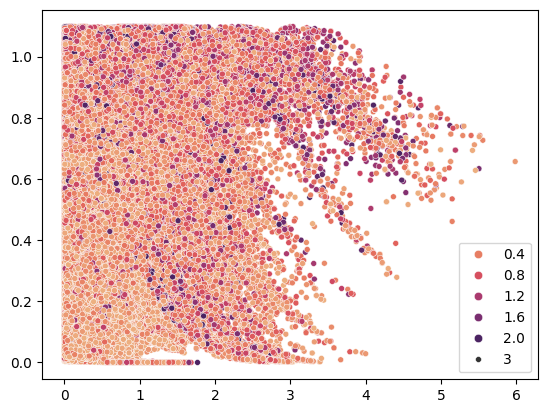

In [748]:
sns.scatterplot(x=np.abs(z_scores), y=entropies, hue=masked_regr_error, palette="flare", size=3)

In [749]:
spearmanr(np.abs(z_scores), masked_regr_error)

SignificanceResult(statistic=np.float64(0.16735932864886036), pvalue=np.float64(0.0))

<Axes: >

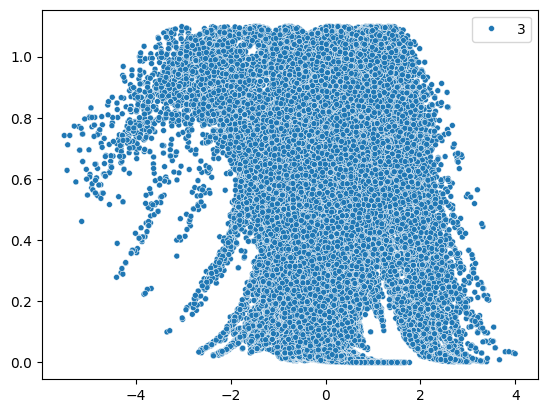

In [725]:
sns.scatterplot(x=z_scores[correct_mask], y=entropies[correct_mask], size=3)

<Axes: >

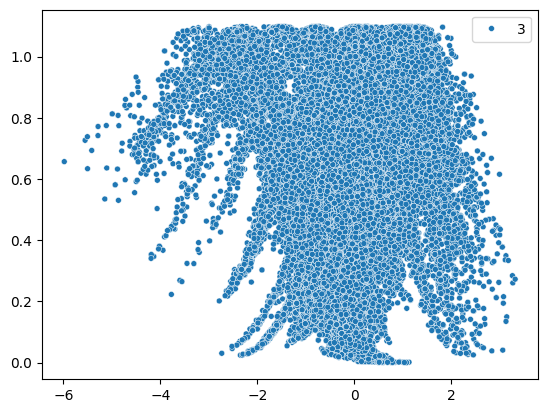

In [726]:
sns.scatterplot(x=z_scores[~correct_mask], y=entropies[~correct_mask], size=3)

In [ ]:
# test no dropout and lower CE weight

In [724]:
correct_mask.shape, entropies.shape, z_scores.shape

((512158,), (512158,), (512158,))

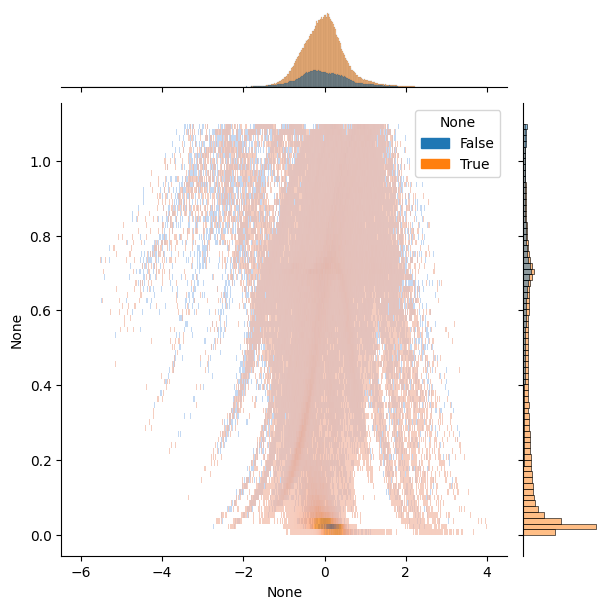

In [754]:
sns.jointplot(x=z_scores, y=entropies, hue=correct_mask, kind="hist", alpha=0.7)

### RANDOM SHUFFLE

In [756]:
CNN_S_REG_CLS_NEW["masked_regr_targets"].shape

(485611,)

In [127]:
shuffled_masked_targets_cls = np.random.permutation(CNN_S_REG_CLS_NEW["masked_cls_targets"])
shuffled_masked_targets_regr = np.random.permutation(CNN_S_REG_CLS_NEW["masked_regr_targets"])
shuffled_masked_targets_regr.shape, shuffled_masked_targets_cls.shape

((485611,), (485611,))

In [128]:
RND_report = classification_report(CNN_S_REG_CLS_NEW["masked_cls_targets"], 
                                   shuffled_masked_targets_cls, 
                                   labels=range(3), digits=4, zero_division=0)

In [129]:
print(RND_report)

              precision    recall  f1-score   support

           0     0.1283    0.1283    0.1283     61277
           1     0.4793    0.4793    0.4793    233447
           2     0.3908    0.3908    0.3908    190887

    accuracy                         0.4002    485611
   macro avg     0.3328    0.3328    0.3328    485611
weighted avg     0.4002    0.4002    0.4002    485611



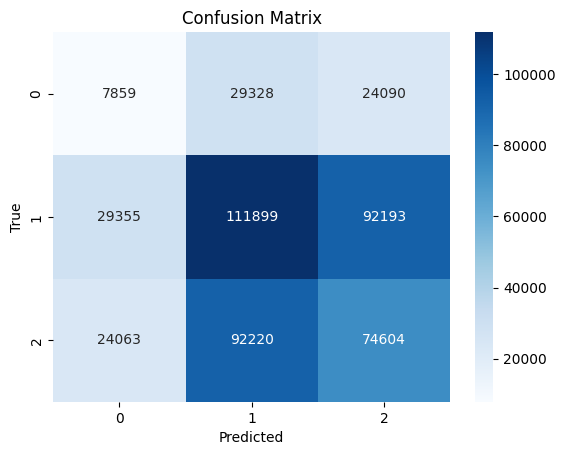

In [130]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_S_REG_CLS_NEW["masked_cls_targets"], shuffled_masked_targets_cls, rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [131]:
spearmanr(CNN_S_REG_CLS_NEW["masked_regr_targets"], shuffled_masked_targets_regr)

SignificanceResult(statistic=np.float64(-0.0007809604442716516), pvalue=np.float64(0.5862920343618748))

In [132]:
mean_absolute_error(CNN_S_REG_CLS_NEW["masked_regr_targets"], shuffled_masked_targets_regr)

1.1204698085784912

In [133]:
r2_score(CNN_S_REG_CLS_NEW["masked_regr_targets"], shuffled_masked_targets_regr)

-1.0009257793426514

Text(0, 0.5, 'RND Predicted frustration')

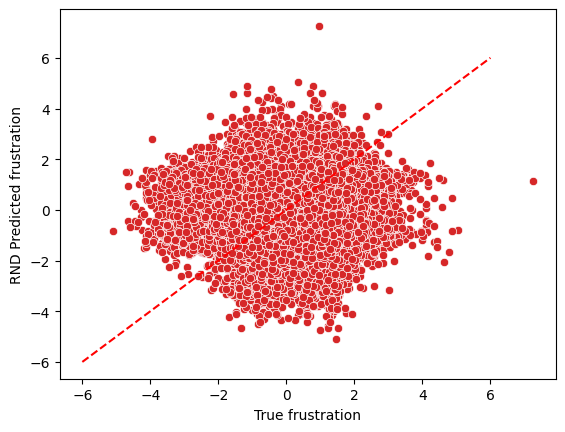

In [134]:
sns.scatterplot(x=CNN_S_REG_CLS_NEW["masked_regr_targets"], y=shuffled_masked_targets_regr, color="C3")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("RND Predicted frustration")

Text(39.222222222222214, 0.5, 'RND Predicted frustration')

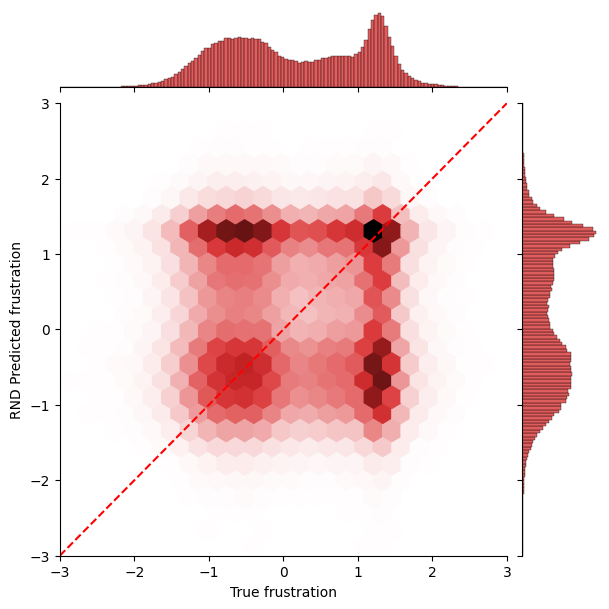

In [135]:
sns.jointplot(x=CNN_S_REG_CLS_NEW["masked_regr_targets"], y=shuffled_masked_targets_regr, kind="hex", xlim=(-3,3), ylim=(-3,3), color="C3")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("RND Predicted frustration")

### Table

In [308]:
models = {"CLS": "../data/it4/it4_S_cls_protT5_setnew_val_preds.npz",
          "JOINT": "../data/it4/it4_S_reg_cls_protT5_setnew_val_preds.npz",
          "JOINT_W": "../data/it4/it4_S_reg_cls_protT5_setnew_ceweights_val_preds.npz",
          "JOINT_QK": "../data/it4/it4_S_reg_cls_protT5_setnew_loraQK_val_preds.npz",
          "JOINT_ALL": "../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_val_preds.npz",
          "JOINT_ALL_W": "../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_ceweight_val_preds.npz",
          "REG_BIN": "../data/it4/it4_S_reg_protT5_setnew_val_preds_2.npz",
          "JOINT_BIN": "../data/it4/it4_S_reg_cls_protT5_setnew_val_preds.npz",
          "JOINT_W_BIN": "../data/it4/it4_S_reg_cls_protT5_setnew_ceweights_val_preds.npz",
          "JOINT_QK_BIN": "../data/it4/it4_S_reg_cls_protT5_setnew_loraQK_val_preds.npz",
          "JOINT_ALL_BIN": "../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_val_preds.npz",
          "JOINT_ALL_W_BIN": "../data/it4/it4_S_reg_cls_protT5_setnew_loraAll_ceweight_val_preds.npz",
          }

In [309]:
model_metrics = run_eval_metrics(np.load(models["JOINT"]), return_cls_report_dict=True)

In [321]:
df = pd.DataFrame(columns=["model", 
                           "macro_precision", "macro_recall", "macro_f1", 
                           "cls0_precision", "cls0_recall", "cls0_f1", 
                           "cls1_precision", "cls1_recall", "cls1_f1", 
                           "cls2_precision", "cls2_recall", "cls2_f1"])

In [322]:
for key, path in models.items():
    if "CLS" in key:
        model_metrics = run_eval_metrics(np.load(path), return_cls_report_dict=True, regression=False)
    elif "BIN" in key:
        model_metrics = run_eval_metrics(np.load(path), return_cls_report_dict=True, bin_regression_for_classification=True)
    else:
        model_metrics = run_eval_metrics(np.load(path), return_cls_report_dict=True)
    row = {"model": key, 
           "macro_precision": round(model_metrics["cls_report"]["macro avg"]["precision"], 3), 
           "macro_recall": round(model_metrics["cls_report"]["macro avg"]["recall"], 3), 
           "macro_f1": round(model_metrics["cls_report"]["macro avg"]["f1-score"], 3), 
           "cls0_precision": round(model_metrics["cls_report"]["0"]["precision"], 3), 
           "cls0_recall": round(model_metrics["cls_report"]["0"]["recall"], 3), 
           "cls0_f1": round(model_metrics["cls_report"]["0"]["f1-score"], 3), 
           "cls1_precision": round(model_metrics["cls_report"]["1"]["precision"], 3), 
           "cls1_recall": round(model_metrics["cls_report"]["1"]["recall"], 3), 
           "cls1_f1": round(model_metrics["cls_report"]["1"]["f1-score"], 3), 
           "cls2_precision": round(model_metrics["cls_report"]["2"]["precision"], 3), 
           "cls2_recall": round(model_metrics["cls_report"]["2"]["recall"], 3), 
           "cls2_f1": round(model_metrics["cls_report"]["2"]["f1-score"], 3)}
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

/var/folders/6b/fx6pp2w50tjc2skb5z2mjxph0000gn/T/ipykernel_22545/101083135.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


In [323]:
df

,model,macro_precision,macro_recall,macro_f1,cls0_precision,cls0_recall,cls0_f1,cls1_precision,cls1_recall,cls1_f1,cls2_precision,cls2_recall,cls2_f1
0,CLS,0.756,0.709,0.726,0.641,0.450,0.529,0.760,0.845,0.800,0.868,0.833,0.850
1,JOINT,0.754,0.717,0.731,0.622,0.484,0.544,0.760,0.844,0.800,0.879,0.822,0.850
2,JOINT_W,0.703,0.770,0.703,0.407,0.854,0.551,0.844,0.612,0.709,0.857,0.843,0.850
3,JOINT_QK,0.760,0.731,0.743,0.639,0.516,0.571,0.779,0.828,0.803,0.861,0.849,0.855
4,JOINT_ALL,0.768,0.736,0.749,0.656,0.527,0.584,0.778,0.838,0.807,0.869,0.843,0.856
5,JOINT_ALL_W,0.717,0.778,0.729,0.467,0.809,0.592,0.843,0.665,0.743,0.842,0.862,0.852
6,REG_BIN,0.779,0.657,0.680,0.717,0.276,0.398,0.716,0.906,0.800,0.902,0.788,0.842
7,JOINT_BIN,0.782,0.650,0.675,0.714,0.271,0.393,0.703,0.926,0.799,0.928,0.753,0.831
8,JOINT_W_BIN,0.794,0.647,0.670,0.752,0.248,0.373,0.705,0.929,0.802,0.924,0.762,0.835
9,JOINT_QK_BIN,0.788,0.677,0.704,0.728,0.343,0.467,0.723,0.908,0.805,0.912,0.780,0.841


In [356]:
np.ones((10, 512)).shape

(10, 512)

In [354]:
regr_preds = [np.ones((10, 512)) for _ in range(5)]  # 5 MC dropout samples
reg_preds_array = np.array(regr_preds)  # shape (5, 10, 512)
reg_preds_array.shape

(5, 10, 512)

In [367]:
type(regr_preds)

list

In [368]:
mcd_preds = np.permute_dims(reg_preds_array, (1, 2, 0))
mcd_preds.shape

(10, 512, 5)

In [362]:
CNN_JOINT_FTALL_CE_NEW["preds_dict"]["masks"][:10]

array([[False,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(10, 512))

In [365]:
mcd_preds[CNN_JOINT_FTALL_CE_NEW["preds_dict"]["masks"][:10]]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], shape=(2234, 5))

In [358]:
CNN_JOINT_FTALL_CE_NEW["preds_dict"]["cls_preds"].shape

(47765, 512, 3)

### MC DROPOUT OLD

In [ ]:
data = np.load("../data/it4/it4_joint_ftall_ce_test_mc_dropout_preds.npz")
data.keys()

KeysView(NpzFile '../data/it4/it4_joint_ftall_ce_test_mc_dropout_preds.npz' with keys: full_seqs, masks, regr_preds, cls_preds, regr_targets...)

In [ ]:
padded_seqs = []
for seq in data["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
seq_array = np.array([list(seq) for seq in padded_seqs])
masked_residues = seq_array[data["masks"]]
masked_residues.shape

(512158,)

In [ ]:
mcd_preds = data["mcd_masked_regr_preds"]  # shape (num_residues, mc_dropout_n)
mcd_preds.shape

(512158, 100)

In [ ]:
avg_preds = mcd_preds.mean(axis=-1)
var_preds = mcd_preds.var(axis=-1)
std_preds = mcd_preds.std(axis=-1)
avg_preds.shape, var_preds.shape, std_preds.shape

((512158,), (512158,), (512158,))

<Axes: ylabel='Count'>

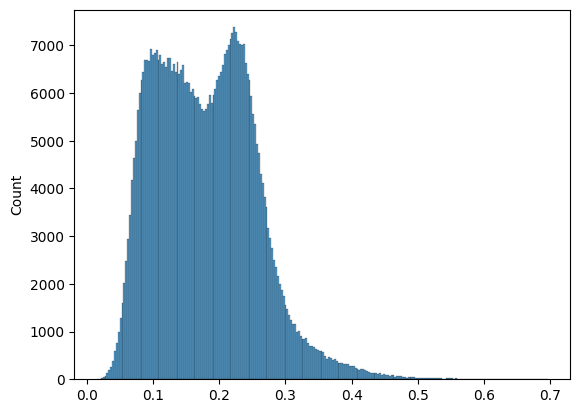

In [ ]:
sns.histplot(std_preds)

In [ ]:
spearmanr(data["masked_regr_targets"], avg_preds), \
mean_absolute_error(data["masked_regr_targets"], avg_preds), \
r2_score(data["masked_regr_targets"], avg_preds)

(SignificanceResult(statistic=np.float64(0.8586145383368733), pvalue=np.float64(0.0)),
 0.33777812123298645,
 0.7346785068511963)

In [ ]:
spearmanr(data["masked_regr_targets"], data["masked_regr_preds"]), \
mean_absolute_error(data["masked_regr_targets"], data["masked_regr_preds"]), \
r2_score(data["masked_regr_targets"], data["masked_regr_preds"])

(SignificanceResult(statistic=np.float64(0.858909422606791), pvalue=np.float64(0.0)),
 0.33716532588005066,
 0.7350736856460571)

In [ ]:
masked_mae = np.abs(data["masked_regr_targets"] - data["masked_regr_preds"])
masked_mae.shape

(512158,)

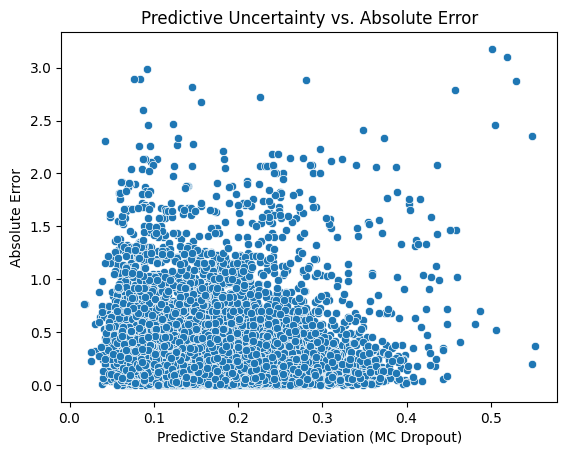

In [ ]:
sns.scatterplot(x=np.sqrt(var_preds[:10000]), y=masked_mae[:10000])
plt.xlabel('Predictive Standard Deviation (MC Dropout)')
plt.ylabel('Absolute Error')
plt.title('Predictive Uncertainty vs. Absolute Error')
plt.show()

In [ ]:
spearmanr(np.sqrt(var_preds), masked_mae)

SignificanceResult(statistic=np.float64(-0.21022558283122578), pvalue=np.float64(0.0))

In [ ]:
data["masked_regr_targets"].reshape(-1, 1).shape

(512158, 1)

In [ ]:
data["masked_regr_targets"].shape

(512158,)

In [ ]:
mcd_preds[:10].T.shape

(100, 10)

In [ ]:
mcd_preds[0].mean()

np.float32(1.1087879)

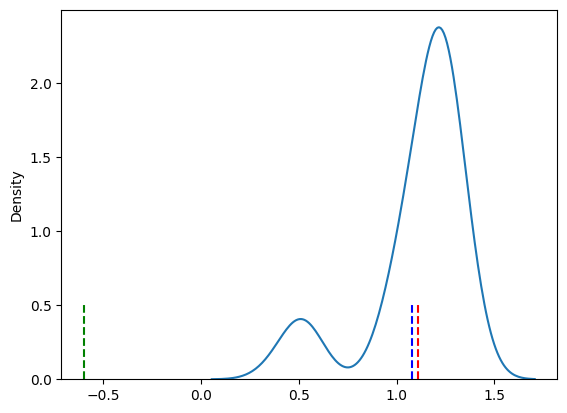

In [ ]:
sns.kdeplot(mcd_preds[0])
plt.vlines(mcd_preds[0].mean(), ymin=0, ymax=0.5, colors='r', linestyles='dashed')
plt.vlines(data["masked_regr_targets"][0], ymin=0, ymax=0.5, colors='g', linestyles='dashed')
plt.vlines(data["masked_regr_preds"][0], ymin=0, ymax=0.5, colors='b', linestyles='dashed')

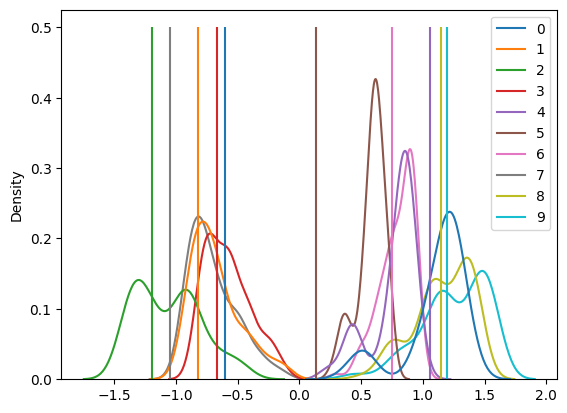

In [ ]:
n = 10
sns.kdeplot(mcd_preds[:n].T)
for i in range(n):
    plt.vlines(data["masked_regr_targets"][i], ymin=0, ymax=0.5, colors=f"C{i}")